# TP 2 - Visión por Computadora 1

## Enunciado:

#### - Implementar la función create_gauss_filter (h, w, k_size, sigma) , para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.
1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.
2. Comparar el resultado de hacer un filtrado por convolución con el mismo kernel

#### - Para la imagen suministrada “metal grid ”. Implementar un algoritmo que:
1. Calcule los gradientes en la imagen (dirección y módulo)
2. Muestre imágenes de ángulo y módulo
3. Marque con colores las direcciones de gradientes más representativos.

### Funciones y variables globales

In [1]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import itertools

In [2]:
def get_kernel_coordinates(h, w, k_size): 
    x_start = w // 2 - k_size // 2
    x_end = x_start + k_size
    y_start = h // 2 - k_size // 2
    y_end = y_start + k_size
    return (x_start, x_end, y_start, y_end)

In [3]:
def plot_kernel_and_tf(kernel, kernel_tf, k_size, sigma):
    plt.figure(figsize=(5, 5))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title(f"Kernel Gausiano - k={k_size}, s={sigma}")
    plt.imshow(kernel, cmap='jet')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title(f"FFT del kernel - k={k_size}, s={sigma}")
    plt.imshow(np.abs(kernel_tf), cmap='jet')
    plt.tight_layout()
    plt.show()

### 1. Implementación Gauss Filter

In [4]:
def create_gauss_filter(h, w, k_size=15, sigma=5):
    canvas = np.zeros((h, w))
    k_1d = cv.getGaussianKernel(k_size, sigma)      
    k_2d = np.dot(k_1d, k_1d.T)     
    x_start, x_end, y_start, y_end = get_kernel_coordinates(h, w, k_size)
    canvas[y_start : y_end, x_start : x_end] = k_2d   
    return canvas, np.fft.fft2(canvas)

#### 1.1.1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma:

In [5]:
k_sizes = [5, 10, 15]
sigmas = [5, 10, 15]

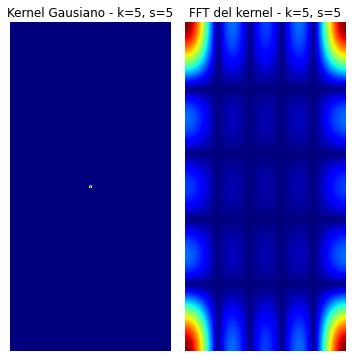

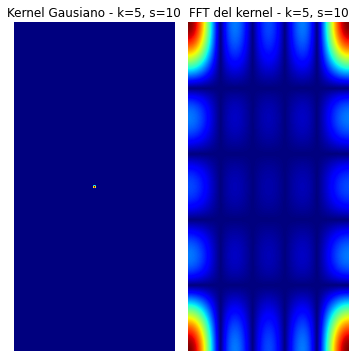

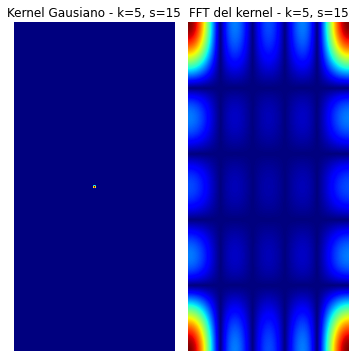

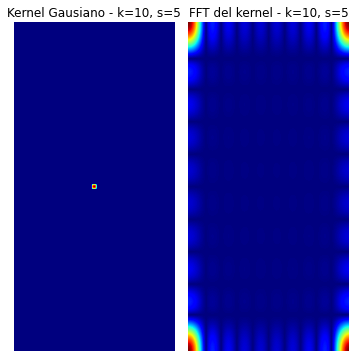

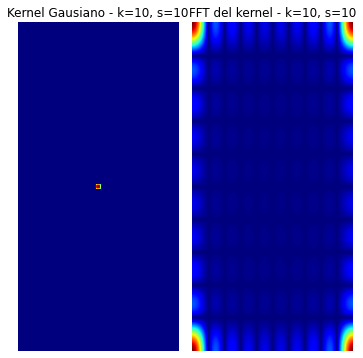

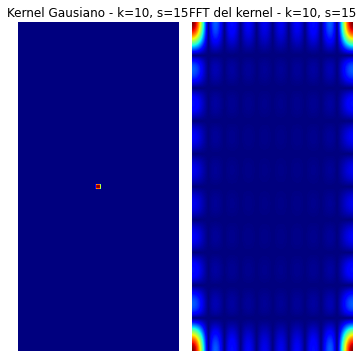

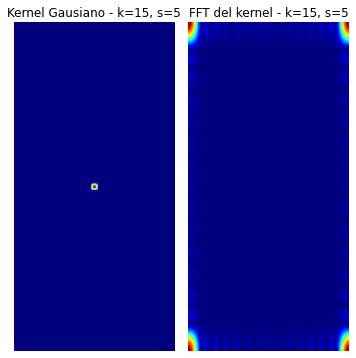

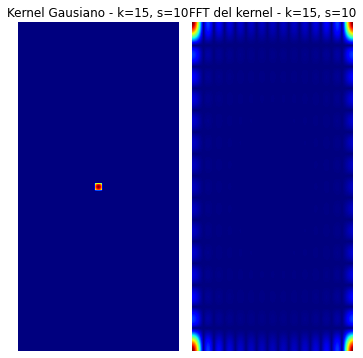

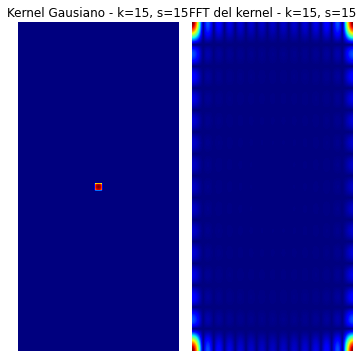

In [6]:
for k, s in itertools.product(k_sizes, sigmas):
    kernel, kernel_tf = create_gauss_filter(h=698, w=341, k_size=k, sigma=s)
    plot_kernel_and_tf(kernel, kernel_tf, k, s)

#### 1.1.2. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.

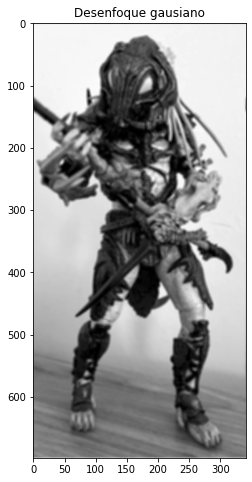

In [7]:
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)

kernel, kernel_tf = create_gauss_filter(h=698, w=341, k_size=5, sigma=5)
img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf

img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

plt.figure(figsize=(8,8))
plt.imshow(img_gauss, cmap='gray')
plt.title('Desenfoque gausiano')
plt.show()

#### 1.2. Comparar el resultado de hacer un filtrado por convolución con el mismo kernel

In [8]:
def convolutional_filter(image, k_size, sigma):
    k_1d = cv.getGaussianKernel(k_size, sigma)      
    k_2d = np.dot(k_1d, k_1d.T)
    return cv.filter2D(src=image, ddepth=-1, kernel=k_2d)

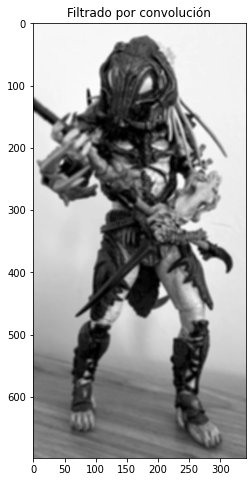

In [9]:
convolved_filtered = convolutional_filter(img, k_size=5, sigma=5)

plt.figure(figsize=(8,8))
plt.imshow(convolved_filtered, cmap='gray')
plt.title('Filtrado por convolución')
plt.show()

- Al hacer un filtrado por convolución con el mismo kernel, obtenemos resultados similares a los del punto anterior.

## 2. Procesamiento imagen “metal grid ”

### Cargamos la imagen

In [10]:
metal_grid = cv.imread('metalgrid.jpg', cv.IMREAD_GRAYSCALE)

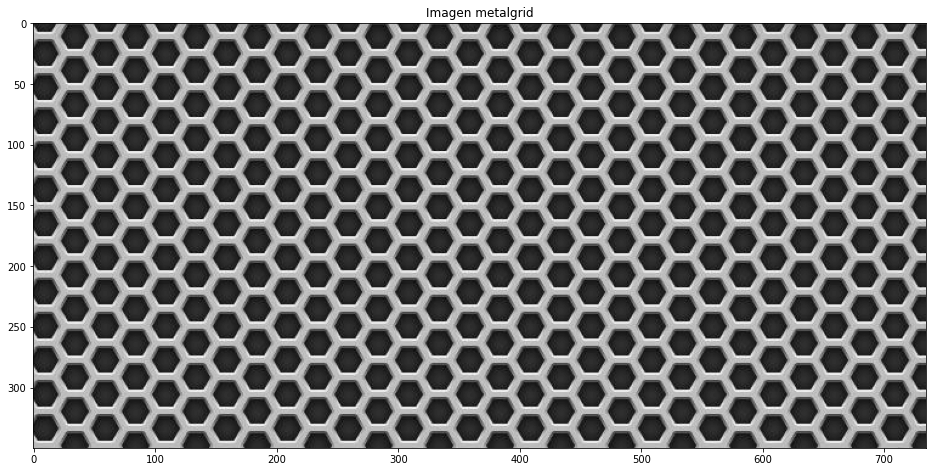

In [11]:
plt.figure(figsize=(16, 16))
plt.imshow(metal_grid, cmap='gray')
plt.title('Imagen metalgrid')
plt.show()

### 2.1. Calcule los gradientes en la imagen (dirección y módulo)

In [12]:
def get_magnitude_and_angle(image):
    # Suavizado Gaussiano
    blur = cv.GaussianBlur(image, (5,5), 0)

    # Gradientes
    #===========
    # Aplicamos Sobelx en 'float32' y luego convertimos de nuevo a 8-bit para evitar overflow
    sobelx_64 = cv.Sobel(blur,cv.CV_32F,1,0,ksize=3)
    absx_64 = np.absolute(sobelx_64)
    sobelx_8u1 = absx_64/absx_64.max()*255
    sobelx_8u = np.uint8(sobelx_8u1)

    # De igual modo para Sobely
    sobely_64 = cv.Sobel(blur,cv.CV_32F,0,1,ksize=3)
    absy_64 = np.absolute(sobely_64)
    sobely_8u1 = absy_64/absy_64.max()*255
    sobely_8u = np.uint8(sobely_8u1)

    # De los gradiente calculamos Magnitud y lo pasamos a 8-bit (Opcional)
    mag = np.hypot(sobelx_8u, sobely_8u)
    mag = mag/mag.max()*255
    mag = np.uint8(mag)

    # Encontramos la Dirección y la pasamos a grados
    theta = np.arctan2(sobely_64, sobelx_64)
    angle = np.rad2deg(theta)
    
    return mag, angle

### 2.2 Muestre imágenes de ángulo y módulo

In [13]:
mag, angle = get_magnitude_and_angle(metal_grid)

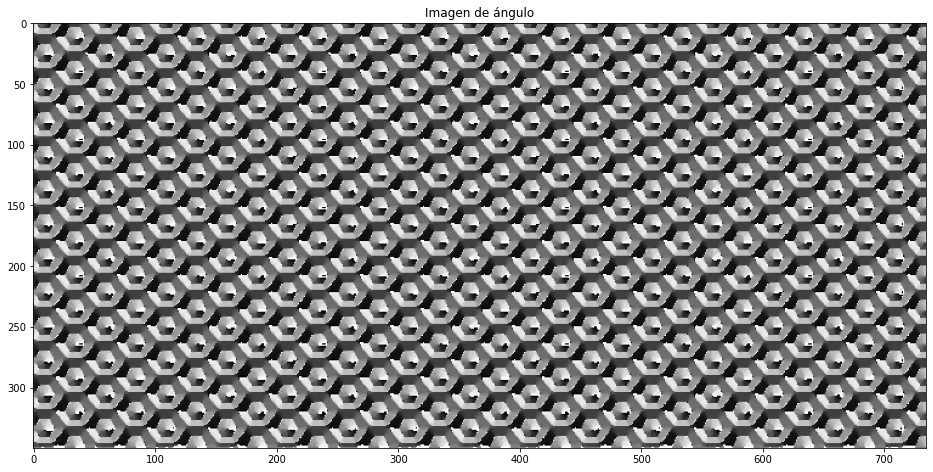

In [14]:
plt.figure(figsize=(16, 16))
plt.imshow(angle, cmap='gray')
plt.title('Imagen de ángulo')
plt.show()

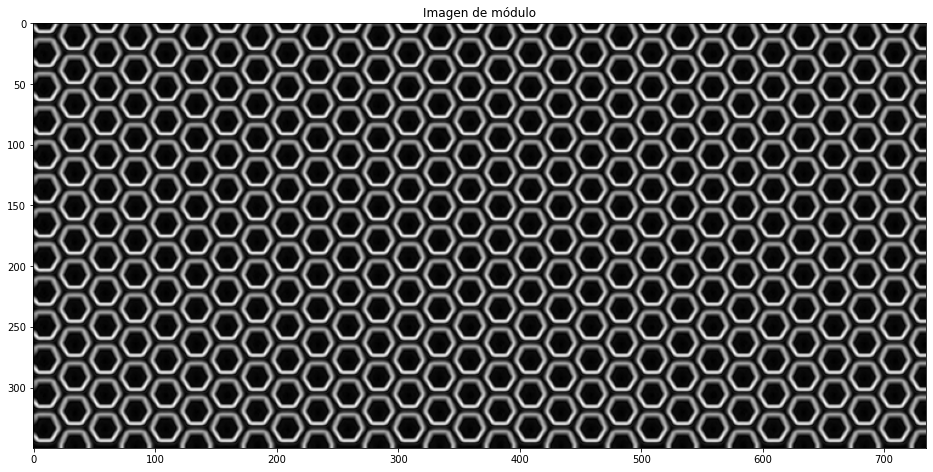

In [15]:
plt.figure(figsize=(16, 16))
plt.imshow(mag, cmap='gray')
plt.title('Imagen de módulo')
plt.show()

### 2.3. Marque con colores las direcciones de gradientes más representativos.

In [16]:
red = np.array([255, 0, 0])
green = np.array([0, 255, 0])
blue = np.array([0, 0, 255])
white = np.array([255, 255, 255])
black = np.array([0, 0, 0])

# Encontramos los píxels vecinos (b,c) en la dirección (redondeadea) del gradiente y aplicamos la supresión de no-máximos
M, N = mag.shape
canvas = np.zeros((M, N, 3), dtype= np.uint8)

color = black

for i in range(1,M-1):
    for j in range(1,N-1):
       # Horizontal 0
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
            color = red
            b = mag[i, j+1]
            c = mag[i, j-1]
        # Diagonal 45
        elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
            color = green
            b = mag[i+1, j+1]
            c = mag[i-1, j-1]
        # Vertical 90
        elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
            color = blue
            b = mag[i+1, j]
            c = mag[i-1, j]
        # Diagonal 135
        elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
            color = white
            b = mag[i+1, j-1]
            c = mag[i-1, j+1]           
            
        # Supresión de no-máximos
        if (mag[i,j] >= b) and (mag[i,j] >= c):
            canvas[i,j] = color
        else:
            canvas[i,j] = black

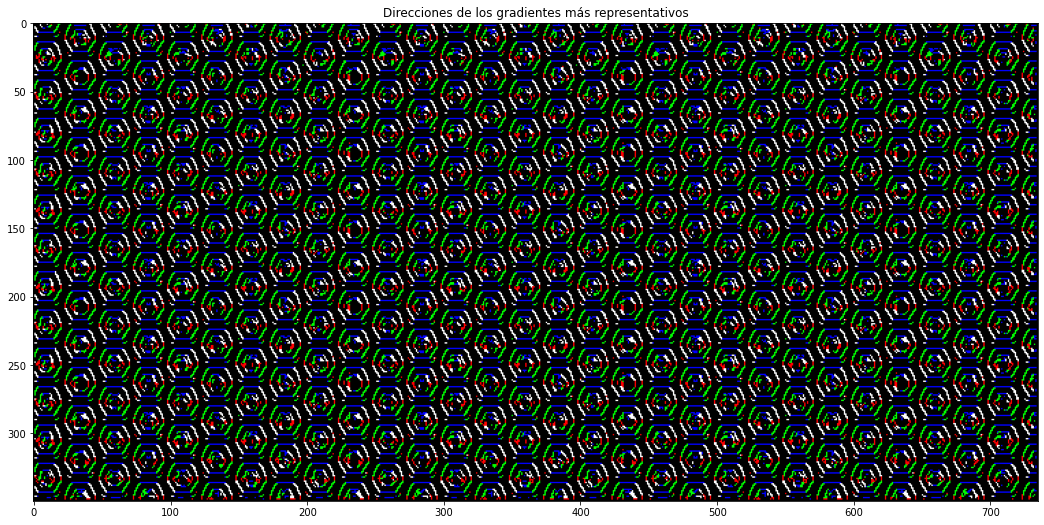

In [17]:
plt.figure(figsize=(18, 18))
plt.imshow(canvas)
plt.title('Direcciones de los gradientes más representativos')
plt.show()